In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import Model, layers
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# Pipeline Saving
from pickle import dump
from io import StringIO
import joblib
from keras.models import model_from_json
import json


c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

# ML Model Training

In [3]:
def train_preprocess():
    df_train = pd.read_csv('Datasets/csv_result-KDDTrain+.csv')
    df_train.drop(['id'], axis = 'columns' , inplace = True)
    
    #for i in range(11,20):
        #df_train.drop(df_train.columns[i],axis='columns',inplace=True)
        
    num_features = len(df_train.columns) - 1
    print('Number of features before feature selection :',num_features)
    print('Original dataset duplicates :',df_train.duplicated().sum())

    num_features = len(df_train.columns) - 1
    print('Number of features after feature selection :',num_features)
    print('Duplicates after feature selection :',df_train.duplicated().sum())
    for col in ['protocol_type','flag','service']:
        df_train[col] = df_train[col].astype('category')
    
    label1 = 'Other_service'
    others1 = df_train['service'].value_counts().index[30:]
    df_train['service'] = df_train['service'].cat.add_categories([label1])
    df_train['service'] = df_train['service'].replace(others1, label1)

    df_train['service'].replace({'time':'Other_service','urp_i':'Other_service',
                                 'csnet_ns':'Other_service','supdup':'Other_service',
                                 'discard':'Other_service','http_443':'Other_service'}, inplace = True)
    
    print('Duplicates after category reduction :',df_train.duplicated().sum())
    df_train['class'] = df_train['class'].map( {'normal':0, 'anomaly':1} )
    df_train.drop_duplicates(keep='first',inplace=True)
    print('Duplicates after duplicate drop :',df_train.duplicated().sum())
    df_train.reset_index(drop=True,inplace=True)
    
    return df_train
df_train = train_preprocess()

Number of features before feature selection : 41
Original dataset duplicates : 9
Number of features after feature selection : 41
Duplicates after feature selection : 9
Duplicates after category reduction : 1468
Duplicates after duplicate drop : 0


In [4]:
df_train.shape

(124505, 42)

In [5]:
limit1 = df_train.shape[1]-1
    
X_train = df_train.iloc[:,0:limit1] # train set features
y_train = df_train.iloc[:,limit1]

In [43]:
y_train.iloc[5]

1

In [6]:
categorical_cols = ['protocol_type','flag','service']
std_cols = ['duration','src_bytes','dst_bytes', 'land', 'wrong_fragment', 
            'urgent', 'hot','num_failed_logins', 'logged_in', 'num_compromised', 'root_shell','su_attempted', 
            'num_root', 'num_file_creations', 'num_shells','num_access_files', 'num_outbound_cmds', 'is_host_login',
            'is_guest_login', 'count', 'srv_count', 'serror_rate','srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
            'same_srv_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count','dst_host_srv_count', 
            'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate', 
            'dst_host_serror_rate','dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate']

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore')
std_scaler = StandardScaler()

columnTransformer = make_column_transformer(
    ( ohe, categorical_cols),
    (std_scaler,std_cols), 
    remainder='passthrough')

In [8]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [9]:
X_train.shape

(124505, 41)

In [10]:
def neural_network(optimizer='sgd', init='glorot_uniform'):
    #Neural Network Model
    model = Sequential()
    model.add(Dense(256, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = METRICS)
    
    return model

In [11]:
estimator = KerasClassifier(build_fn=neural_network,verbose=1,epochs=100, batch_size=128)

In [12]:
def evaluation(y, y_pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_pred,normalize= 'true')
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    accuracy = accuracy_score(y,y_pred)
    f1 = f1_score(y,y_pred)
    print('\n')
    print('===========================================================================================================')
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='.4f', annot_kws=    {'size':12})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(title, fontsize=18)
    
    plt.show();

In [13]:
def cross_validate(classifier, cv):
    
    pipeline = Pipeline(
        steps=[('preprocessing',columnTransformer),
               ('classifier',estimator)])
    
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t,y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
        
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')
    
    return pipeline

Epoch 1/100
99604/99604 [==============================] - 4s 42us/step - loss: 0.2050 - accuracy: 0.8675 - precision: 0.8334 - recall: 0.9296 - auc: 0.9588
Epoch 2/100
99604/99604 [==============================] - 4s 36us/step - loss: 0.0848 - accuracy: 0.9484 - precision: 0.9460 - recall: 0.9409 - auc: 0.9837
Epoch 3/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0680 - accuracy: 0.9604 - precision: 0.9625 - recall: 0.9507 - auc: 0.9886
Epoch 4/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0547 - accuracy: 0.9662 - precision: 0.9698 - recall: 0.9560 - auc: 0.9914
Epoch 5/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0430 - accuracy: 0.9698 - precision: 0.9738 - recall: 0.9599 - auc: 0.9934
Epoch 6/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0358 - accuracy: 0.9728 - precision: 0.9765 - recall: 0.9637 - auc: 0.9947
Epoch 7/100
99604/99604 [==============================] -

99604/99604 [==============================] - 4s 36us/step - loss: 0.0124 - accuracy: 0.9925 - precision: 0.9928 - recall: 0.9907 - auc: 0.9994
Epoch 53/100
99604/99604 [==============================] - 4s 36us/step - loss: 0.0116 - accuracy: 0.9925 - precision: 0.9929 - recall: 0.9908 - auc: 0.9994
Epoch 54/100
99604/99604 [==============================] - 4s 36us/step - loss: 0.0115 - accuracy: 0.9926 - precision: 0.9930 - recall: 0.9909 - auc: 0.9994
Epoch 55/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0117 - accuracy: 0.9927 - precision: 0.9930 - recall: 0.9910 - auc: 0.9994
Epoch 56/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0133 - accuracy: 0.9928 - precision: 0.9931 - recall: 0.9911 - auc: 0.9994
Epoch 57/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0114 - accuracy: 0.9928 - precision: 0.9932 - recall: 0.9912 - auc: 0.9994
Epoch 58/100
99604/99604 [==============================] - 4s 39

99604/99604 [==============================] - 4s 38us/step - loss: 0.0671 - accuracy: 0.9939 - precision: 0.9944 - recall: 0.9924 - auc: 0.9995
Epoch 4/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0536 - accuracy: 0.9938 - precision: 0.9943 - recall: 0.9922 - auc: 0.9995
Epoch 5/100
99604/99604 [==============================] - 4s 41us/step - loss: 0.0417 - accuracy: 0.9937 - precision: 0.9942 - recall: 0.9920 - auc: 0.9995
Epoch 6/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0343 - accuracy: 0.9937 - precision: 0.9942 - recall: 0.9919 - auc: 0.9995
Epoch 7/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0304 - accuracy: 0.9936 - precision: 0.9941 - recall: 0.9919 - auc: 0.9995
Epoch 8/100
99604/99604 [==============================] - 4s 41us/step - loss: 0.0278 - accuracy: 0.9936 - precision: 0.9941 - recall: 0.9919 - auc: 0.9995
Epoch 9/100
99604/99604 [==============================] - 4s 41us/ste

99604/99604 [==============================] - 4s 41us/step - loss: 0.0101 - accuracy: 0.9942 - precision: 0.9946 - recall: 0.9927 - auc: 0.9995
Epoch 55/100
99604/99604 [==============================] - 4s 41us/step - loss: 0.0103 - accuracy: 0.9942 - precision: 0.9946 - recall: 0.9927 - auc: 0.9995
Epoch 56/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0106 - accuracy: 0.9942 - precision: 0.9946 - recall: 0.9927 - auc: 0.9995
Epoch 57/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0098 - accuracy: 0.9942 - precision: 0.9946 - recall: 0.9927 - auc: 0.9995
Epoch 58/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0096 - accuracy: 0.9942 - precision: 0.9946 - recall: 0.9927 - auc: 0.9996
Epoch 59/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0095 - accuracy: 0.9943 - precision: 0.9947 - recall: 0.9928 - auc: 0.9996
Epoch 60/100
99604/99604 [==============================] - 4s 40

99604/99604 [==============================] - 4s 37us/step - loss: 0.0375 - accuracy: 0.9947 - precision: 0.9951 - recall: 0.9928 - auc: 0.9996
Epoch 6/100
99604/99604 [==============================] - 4s 39us/step - loss: 0.0322 - accuracy: 0.9946 - precision: 0.9951 - recall: 0.9928 - auc: 0.9996
Epoch 7/100
99604/99604 [==============================] - 4s 39us/step - loss: 0.0286 - accuracy: 0.9946 - precision: 0.9950 - recall: 0.9928 - auc: 0.9996
Epoch 8/100
99604/99604 [==============================] - 4s 39us/step - loss: 0.0268 - accuracy: 0.9946 - precision: 0.9950 - recall: 0.9928 - auc: 0.9996
Epoch 9/100
99604/99604 [==============================] - 4s 39us/step - loss: 0.0246 - accuracy: 0.9946 - precision: 0.9950 - recall: 0.9928 - auc: 0.9996
Epoch 10/100
99604/99604 [==============================] - 4s 40us/step - loss: 0.0240 - accuracy: 0.9946 - precision: 0.9950 - recall: 0.9928 - auc: 0.9996
Epoch 11/100
99604/99604 [==============================] - 4s 37us/s

99604/99604 [==============================] - 4s 38us/step - loss: 0.0104 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9931 - auc: 0.9996
Epoch 57/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0105 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9931 - auc: 0.9996
Epoch 58/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0116 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9931 - auc: 0.9996
Epoch 59/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0104 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9931 - auc: 0.9996
Epoch 60/100
99604/99604 [==============================] - 4s 39us/step - loss: 0.0104 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9932 - auc: 0.9996
Epoch 61/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0104 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9932 - auc: 0.9996
Epoch 62/100
99604/99604 [==============================] - 4s 38

99604/99604 [==============================] - 4s 38us/step - loss: 0.0340 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9931 - auc: 0.9996
Epoch 7/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0294 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9931 - auc: 0.9996
Epoch 8/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0276 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9930 - auc: 0.9996
Epoch 9/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0256 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9930 - auc: 0.9996
Epoch 10/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9930 - auc: 0.9996
Epoch 11/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0248 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9930 - auc: 0.9996
Epoch 12/100
99604/99604 [==============================] - 4s 40us/

99604/99604 [==============================] - 4s 37us/step - loss: 0.0115 - accuracy: 0.9955 - precision: 0.9953 - recall: 0.9933 - auc: 0.9996
Epoch 58/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0102 - accuracy: 0.9955 - precision: 0.9953 - recall: 0.9933 - auc: 0.9996
Epoch 59/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0113 - accuracy: 0.9956 - precision: 0.9953 - recall: 0.9933 - auc: 0.9996
Epoch 60/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0103 - accuracy: 0.9956 - precision: 0.9953 - recall: 0.9933 - auc: 0.9996
Epoch 61/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0097 - accuracy: 0.9956 - precision: 0.9953 - recall: 0.9933 - auc: 0.9996
Epoch 62/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0104 - accuracy: 0.9956 - precision: 0.9954 - recall: 0.9933 - auc: 0.9996
Epoch 63/100
99604/99604 [==============================] - 4s 37

99604/99604 [==============================] - 4s 43us/step - loss: 0.0271 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9932 - auc: 0.9996
Epoch 9/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0250 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9932 - auc: 0.9996
Epoch 10/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0241 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9932 - auc: 0.9996
Epoch 11/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0230 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9932 - auc: 0.9996
Epoch 12/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0212 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9932 - auc: 0.9996
Epoch 13/100
99604/99604 [==============================] - 4s 38us/step - loss: 0.0211 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9932 - auc: 0.9996
Epoch 14/100
99604/99604 [==============================] - 4s 40u

99604/99604 [==============================] - 4s 36us/step - loss: 0.0097 - accuracy: 0.9961 - precision: 0.9955 - recall: 0.9934 - auc: 0.9996
Epoch 60/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0105 - accuracy: 0.9961 - precision: 0.9955 - recall: 0.9934 - auc: 0.9996
Epoch 61/100
99604/99604 [==============================] - 4s 39us/step - loss: 0.0098 - accuracy: 0.9961 - precision: 0.9955 - recall: 0.9934 - auc: 0.9996
Epoch 62/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0099 - accuracy: 0.9961 - precision: 0.9955 - recall: 0.9934 - auc: 0.9996
Epoch 63/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0090 - accuracy: 0.9961 - precision: 0.9955 - recall: 0.9934 - auc: 0.9996
Epoch 64/100
99604/99604 [==============================] - 4s 37us/step - loss: 0.0092 - accuracy: 0.9962 - precision: 0.9955 - recall: 0.9934 - auc: 0.9996
Epoch 65/100
99604/99604 [==============================] - 4s 37

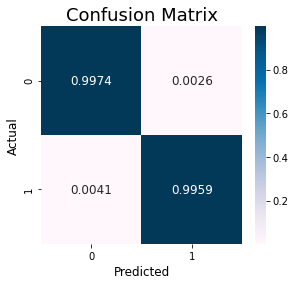

None
Training Accuracy: 0.9975282117184049


Validation Accuracy: 0.9963053692622786




In [14]:
pipe = cross_validate(estimator, KFold())

In [15]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type', 'flag',
                                                   'service']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_she...
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count', ...])])),
                ('classifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020558DC5550>)])

In [16]:
def test_preprocess():
    df_test = pd.read_csv('Datasets/csv_result-KDDTest+.csv')
    df_test.drop(['id'], axis = 'columns' , inplace = True)
    
    #for i in range(11,20):
        #df_train.drop(df_train.columns[i],axis='columns',inplace=True)
        
    for col in ['protocol_type','flag','service']:
        df_test[col] = df_test[col].astype('category')
    
    label1 = 'Other_service'
    others1 = df_test['service'].value_counts().index[30:]
    # apply new category label
    df_test['service'] = df_test['service'].cat.add_categories([label1])
    df_test['service'] = df_test['service'].replace(others1, label1)

    print('Duplicates after category reduction :',df_test.duplicated().sum())
    df_test['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                                'link':'Other_service','name':'Other_service','echo':'Other_service',
                                'netbios_ns':'Other_service'}, inplace = True)
    
    df_test['class'] = df_test['class'].map( {'normal':0, 'anomaly':1} )
    df_test.drop_duplicates(keep='first',inplace=True)
    print('Duplicates after duplicate drop :',df_test.duplicated().sum())
    
    return df_test
df_test = test_preprocess()

Duplicates after category reduction : 22
Duplicates after duplicate drop : 0


In [17]:
limit2 = df_test.shape[1]-1
    
X_test = df_test.iloc[:,0:limit2] # train set features
Y_test = df_test.iloc[:,limit2]

In [18]:
Y_test.iloc[[25]]

25    1
Name: class, dtype: int64

In [19]:
t1 = X_test.iloc[[25]]

In [20]:
test_predictions = pipe.predict(t1)

1/1 [==============================] - 0s 1000us/step


In [21]:
test_predictions

array([[1]], dtype=int64)

In [22]:
Y1=Y_test.iloc[[25]]

In [23]:
print("Test set accuracy            : {:.4f} %".format(accuracy_score(Y1, test_predictions)*100))

Test set accuracy            : 100.0000 %


In [24]:
x2 = "0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0,0,1,1,0.04,0.06,0,255,10,0.04,0.06,0,0,0,0,1,1"

In [25]:
cc = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes','dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
      'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell','su_attempted', 'num_root', 'num_file_creations', 
      'num_shells','num_access_files', 'num_outbound_cmds', 'is_host_login','is_guest_login', 'count', 'srv_count', 
      'serror_rate','srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate','diff_srv_rate', 'srv_diff_host_rate', 
      'dst_host_count','dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
      'dst_host_srv_diff_host_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate', 'dst_host_rerror_rate',
      'dst_host_srv_rerror_rate']

In [26]:
str_data = StringIO(x2)

In [27]:
df_tt = pd.read_csv(str_data,sep=",",names=cc)

In [28]:
df_tt

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0,0,0,0,1,1


In [29]:
test_predictions = pipe.predict(df_tt)

1/1 [==============================] - 0s 999us/step


In [30]:
test_predictions

array([[1]], dtype=int64)

## Saving ML Model and OneHotEncoder/StandardScaler

In [31]:
# saving model
json_model = estimator.model.to_json()
open('model_architecture.json', 'w').write(json_model)
# saving weights
estimator.model.save_weights('model_weights.h5', overwrite=True)

In [32]:
joblib.dump(pipe,"pipeline.joblib")

['pipeline.joblib']

In [37]:
joblib.dump(columnTransformer,"columnTransformer")

['columnTransformer']

In [38]:
joblib.dump(pipe,"Pipeline")

['Pipeline']

In [33]:
# save the scaler
dump(std_scaler, open('scaler.pkl', 'wb'))
# save the onehotencoder
dump(ohe,open('ohe.pkl','wb'))

In [34]:
print(id(ohe))

2222391192992


In [35]:
print(id(std_scaler))

2222391192376


In [36]:
print(id(estimator))

2221988926800
